In [ ]:
import inspect
import dualcodec
import torch
import os
import numpy as np
import torchaudio
import matplotlib.pyplot as plt
from utils import prepare_data
from IPython.display import Audio

In [ ]:
model_id = "12hz_v1"
dualcodec_model = dualcodec.get_model(model_id)
dualcodec_inference = dualcodec.Inference(dualcodec_model=dualcodec_model, device="cuda")

In [ ]:
dac_model = dualcodec_inference.model.dac

In [ ]:
print(inspect.getsource(dualcodec_inference.decode))
print(inspect.getsource(dualcodec_inference.model.decode_from_codes))

In [ ]:
ds = prepare_data(max_shards=1)
audios = []
sample_rates = []
for i in range(10):                                          
    audio = torch.from_numpy(ds[i]["mp3"]["array"]).float()  # type: ignore[attr-defined] 
    sample_rates.append(ds[i]["mp3"]["sampling_rate"])       # type: ignore[attr-defined]
    audios.append(audio)

In [ ]:
sample, sr = torchaudio.load("tara.wav")
sample = torchaudio.transforms.Resample(orig_freq=sr, new_freq=24000)(sample)
print(sample.shape)

In [ ]:
semantic_code, acoustic_code = dualcodec_inference.encode(sample.reshape(1,1,-1), n_quantizers=8)

In [96]:
dualcodec_inference.model.convnext_decoder

Sequential(
  (0): ConvNeXtBlock(
    (dwconv): Conv1d(768, 768, kernel_size=(7,), stride=(1,), groups=768)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (pwconv1): Linear(in_features=768, out_features=2048, bias=True)
    (act): GELU(approximate='none')
    (pwconv2): Linear(in_features=2048, out_features=768, bias=True)
  )
  (1): ConvNeXtBlock(
    (dwconv): Conv1d(768, 768, kernel_size=(7,), stride=(1,), groups=768)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (pwconv1): Linear(in_features=768, out_features=2048, bias=True)
    (act): GELU(approximate='none')
    (pwconv2): Linear(in_features=2048, out_features=768, bias=True)
  )
  (2): ConvNeXtBlock(
    (dwconv): Conv1d(768, 768, kernel_size=(7,), stride=(1,), groups=768)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (pwconv1): Linear(in_features=768, out_features=2048, bias=True)
    (act): GELU(approximate='none')
    (pwconv2): Linear(in_features=2048, o

In [ ]:
print(max(semantic_code[0][0]))
print(max(acoustic_code[0][5]))

In [ ]:
print(semantic_code.shape)
print(acoustic_code.shape)

In [ ]:
# Give the decoder codes 1-by-1 instead and collect the output samples to see if the decoder works
def calculate_audio_with_receptive(semantic_code, acoustic_code, look_ahead, look_back):
    my_audio = np.array([])
    num_codes = len(semantic_code[0][0])
    assert num_codes == len(acoustic_code[0][0])

    for i in range(0, num_codes):
        l = max(i - look_back, 0)
        r = min(i + look_ahead, num_codes)

        # print(f"looking back {l} tokens, and looking ahead {r} tokens")

        sm = semantic_code[:, :, l:r]
        ac = acoustic_code[:, :, l:r]

        # print(f"num codes given: {r-l}")
        # print(f"num samples generated: {out_audio.shape[0]}")

        out_audio = dualcodec_inference.decode(sm, ac)
        out_audio = out_audio.squeeze(0).squeeze(0).cpu().numpy()

        space = l * 1920

        # print(l, r, len(out_audio), i * 1920 - space)

        my_audio = np.concatenate([my_audio, out_audio[1920 * i - space : 1920 * (i+1) - space]])
        
    return my_audio

In [ ]:
# original audio
Audio(sample.squeeze(0).squeeze(0).cpu().numpy(), rate=24000)
print(sample.shape)

In [ ]:
non_streamed_audio = dualcodec_inference.decode(semantic_code, acoustic_code).squeeze(0).cpu().numpy()
print(non_streamed_audio.shape)
Audio(non_streamed_audio, rate=24000)

In [ ]:
# stream_1 = calculate_audio_with_receptive(semantic_code, acoustic_code, 10, 10)
# stream_2 = calculate_audio_with_receptive(semantic_code, acoustic_code, 20, 20)
# stream_3 = calculate_audio_with_receptive(semantic_code, acoustic_code, 30, 30)


In [ ]:
# stream_4 = calculate_audio_with_receptive(semantic_code, acoustic_code, 40, 40)
# stream_5 = calculate_audio_with_receptive(semantic_code, acoustic_code, 50, 50)
# stream_6 = calculate_audio_with_receptive(semantic_code, acoustic_code, 60, 60)


In [ ]:
# stream_7 = calculate_audio_with_receptive(semantic_code, acoustic_code, 70, 70)
# stream_8 = calculate_audio_with_receptive(semantic_code, acoustic_code, 80, 80)


In [ ]:
stream_9 = calculate_audio_with_receptive(semantic_code, acoustic_code, 5, 5)


In [ ]:
stream_8 = calculate_audio_with_receptive(semantic_code, acoustic_code, 5, 25)

In [ ]:
plt.plot(stream_8, label="stream_8")
plt.plot(stream_9, label="stream_9")
plt.legend()
plt.show()

In [ ]:
Audio(stream_9, rate=24000)


In [ ]:
Audio(stream_8, rate=24000)

In [ ]:
streams = [
    stream_8,
    stream_9,
]

NameError: name 'stream_8' is not defined

In [ ]:
for j, stream in enumerate(streams):
    differences = stream - non_streamed_audio[0]
    plt.plot(differences, label=f"stream_{j+1}")
    plt.legend()
    plt.show()

### DAC

In [18]:
dac_inputs = torch.randn(1, 1024, 252, device="cuda")

In [19]:
non_stream_dac = dac_model.decoder(dac_inputs).squeeze(0).squeeze(0).cpu().detach().numpy()

In [20]:
dac_model.decoder_rates

[2, 8, 6, 5, 4]

In [21]:
def lol(inputs, model_now, look_ahead, look_back, space_cons):
    my_audio = np.array([])
    num_codes = len(inputs[0][0])
    

    for i in range(0, num_codes):
        l = max(i - look_back, 0)
        r = min(i + look_ahead, num_codes)
        
        dac_inputs = inputs[:, :, l:r]

        out_audio = model_now(dac_inputs)
        out_audio = out_audio.squeeze(0).squeeze(0).cpu().detach().numpy()

        space = l * space_cons
        
        # print(f"num samples generated: {out_audio.shape}")
        # print(f"my audio shape: {my_audio.shape}")
        
        my_audio = np.concatenate([
            my_audio, 
            out_audio[space_cons * i - space : space_cons * (i+1) - space]
            ])
        
        # print(f"num samples added so far: {my_audio.shape[0]} at loop {i}")
        
    return my_audio

In [ ]:
streamed_dac_audio = lol(dac_inputs, dac_model.decoder, 65, 55, 1920);
streamed_dac_audio_2 = lol(dac_inputs, dac_model.decoder, 70, 55, 1920);
streamed_dac_audio_3 = lol(dac_inputs, dac_model.decoder, 75, 55, 1920);


In [84]:
streamed_dac_audio_4 = lol(dac_inputs, dac_model.decoder, 55, 75, 1920);

In [85]:
print(non_stream_dac.shape)
print(streamed_dac_audio.shape)
print(streamed_dac_audio_2.shape)
print(streamed_dac_audio_3.shape)

(483836,)
(483836,)
(483836,)
(483836,)


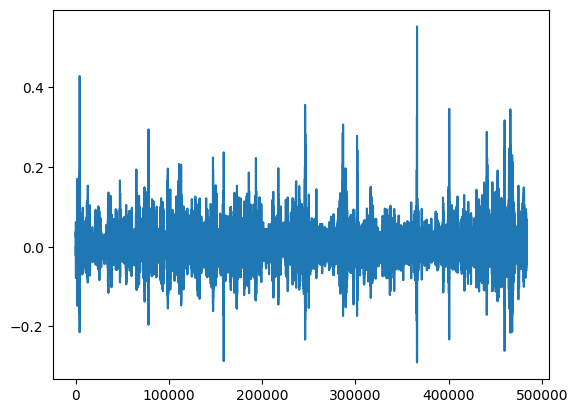

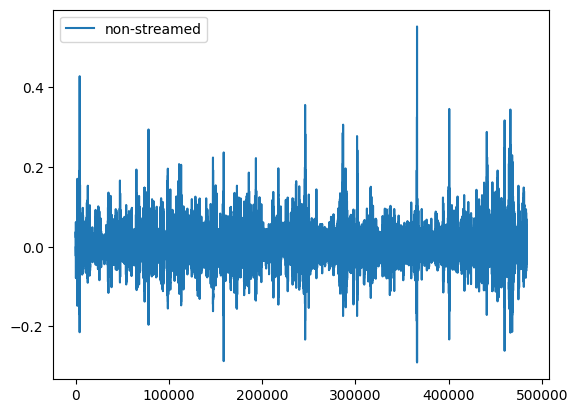

In [86]:
plt.plot(streamed_dac_audio_2, label="streamed")
plt.show()
plt.plot(non_stream_dac, label="non-streamed")
plt.legend()
plt.show()

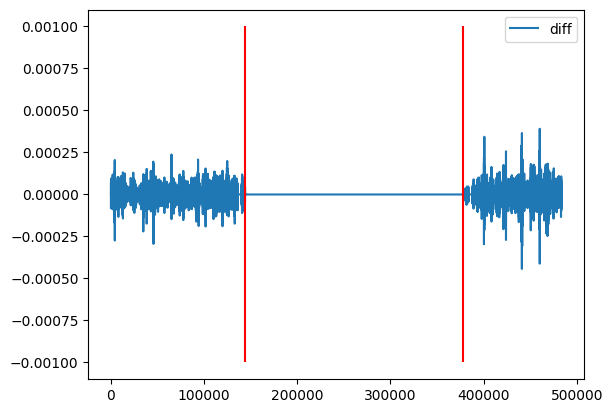

In [88]:
plt.plot(streamed_dac_audio_4 - non_stream_dac, label="diff")
plt.vlines(x=1920 * 75 - 4, ymin=-0.001, ymax=0.001, color="red")
plt.vlines(x=1920 * (252 - 55) - 4, ymin=-0.001, ymax=0.001, color="red")
plt.legend()
plt.show()

In [ ]:
layers = dac_model.decoder.model
print(layers[1])

In [ ]:
def lol(inputs, model_now, look_ahead, look_back, space_cons, num_frames):
    my_audio = np.zeros((inputs.shape[0], inputs.shape[1], num_frames))
    
    for i in range(0, num_frames):
        l = max(i - look_back, 0)
        r = min(i + look_ahead, num_frames)
        
        dac_inputs = inputs[:, :, l:r]

        out_audio = model_now(dac_inputs)
        out_audio = out_audio.cpu().detach().numpy()
        
        print(out_audio.shape)

        space = l * space_cons
        
        my_audio[:, :, i] = out_audio[:, :, space_cons * i - space : space_cons * (i+1) - space]
        
    return my_audio

In [ ]:
dac_outputs_non_stream_1 = layers[0](dac_inputs)
dac_outputs_stream_1 = lol(dac_inputs, layers[0], 1, 1, 1920, dac_inputs.shape[2])



print(dac_outputs_non_stream_1.shape)
print(dac_outputs_stream_1.shape)